In [6]:
import os
import sys
import numpy as np


import umap.umap_ as umap

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


#ALLDIR='/mnt/d/DATA/XFMDATA/2023/Nicholls_Loren/mounts_ansto_230418/230420_qz200um_cut/tiff'
BASEDIR = ""
TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo"
#TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/NC_s4r2"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
#image_directory = ALLDIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo
['/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Al.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-As.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Ca.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Cl.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Compton.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Cr.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Cu.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Fe.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-K.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Mn.ti

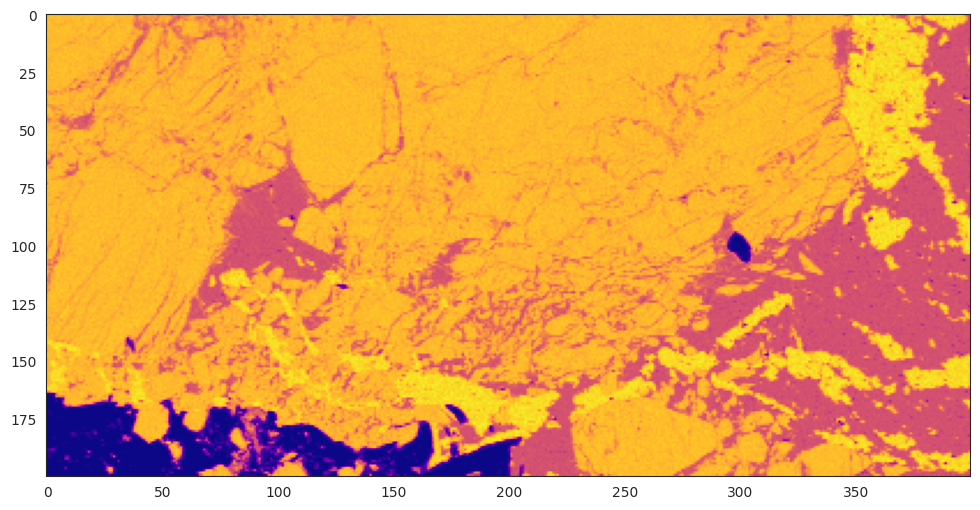

In [7]:
%load_ext autoreload
%autoreload 2

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis

FORCE_EMBED=True
FORCE_CLUST=True
OVERWRITE=True

data, elements, dims = processops.compile(image_directory, 100, 500, 100, 300)
vis.show_map(data, elements, dims, "Fe")

-----Mo tracker: 0.19999998807907104
CALCULATING EMBED
Dimensionality reduction via UMAP across 80000 elements
UMAP(n_neighbors=300, verbose=True)
Tue Jun  6 22:48:17 2023 Construct fuzzy simplicial set
Tue Jun  6 22:48:17 2023 Finding Nearest Neighbors
Tue Jun  6 22:48:17 2023 Building RP forest with 19 trees
Tue Jun  6 22:48:18 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Tue Jun  6 22:49:13 2023 Finished Nearest Neighbor Search
Tue Jun  6 22:49:20 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Jun  6 22:50:11 2023 Finished embedding
CALCULATING CATS
RUNNING CLUSTERING
DBSCAN PARAM 0.1, 0.1
cluster -1, count: 27594
cluster 0, count: 11547
cluster 1, count: 7818
-----Mo tracker: 0.19999998807907104
4
(80000,)
-1
0


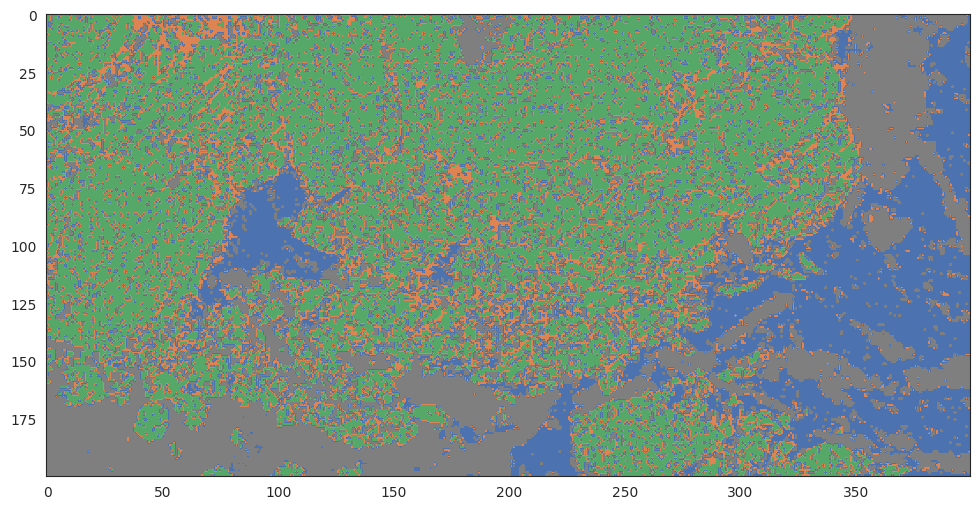

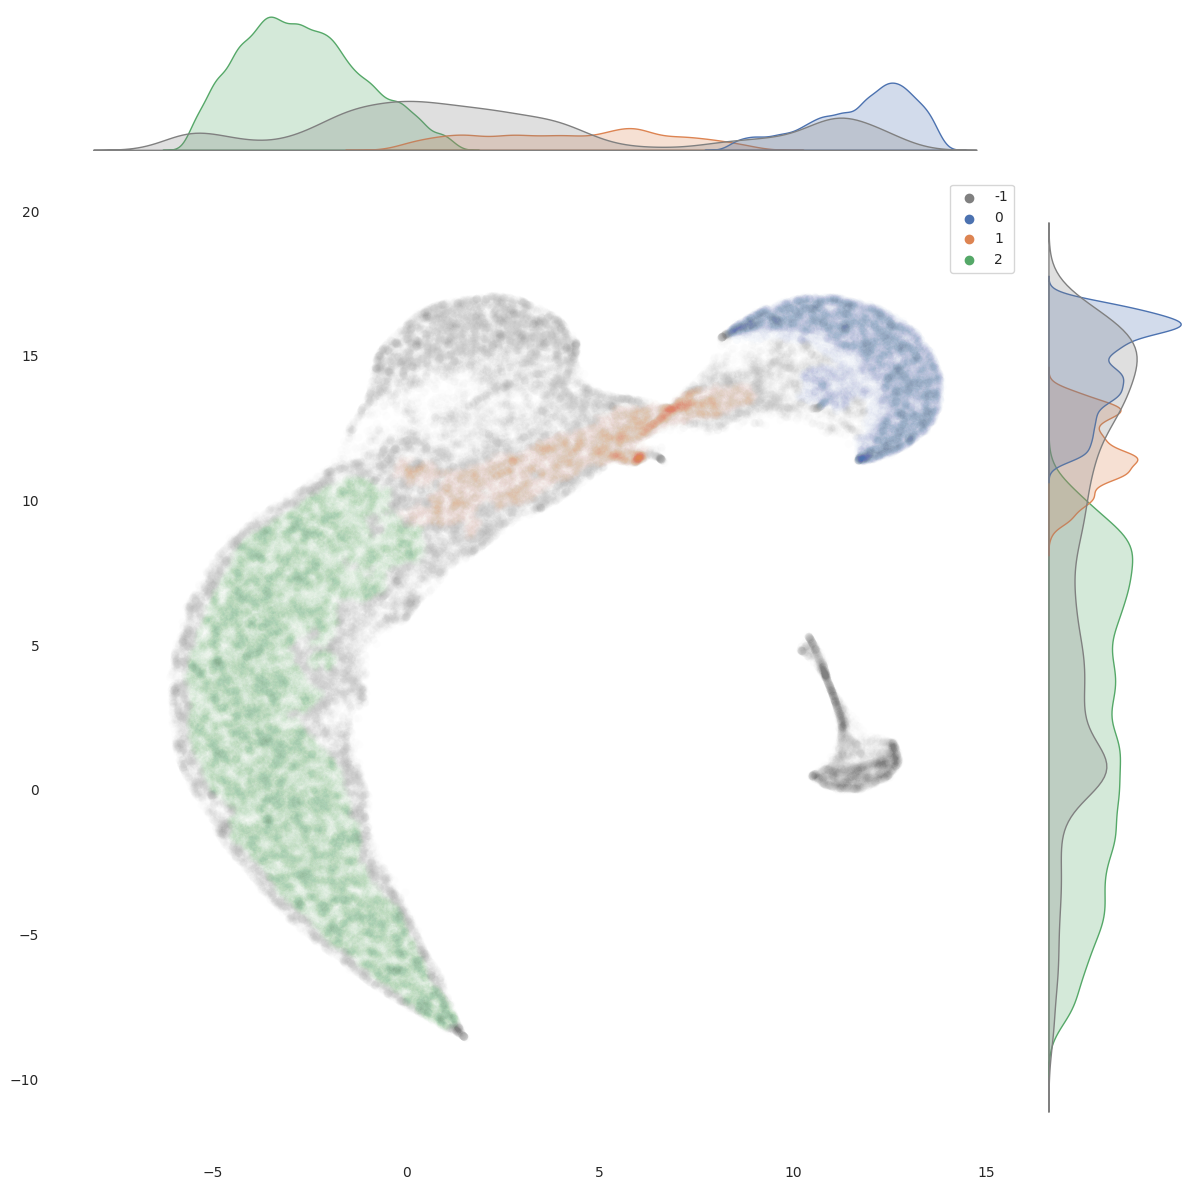

Al, max: 0.03, 98: 0.00, avg: 0.00
As, max: 0.02, 98: 0.01, avg: 0.00
Ca, max: 3.68, 98: 0.44, avg: 0.05
Cl, max: 0.10, 98: 0.02, avg: 0.00
Compton, max: 0.20, 98: 0.02, avg: 0.00
Cr, max: 0.03, 98: 0.02, avg: 0.01
Cu, max: 1.04, 98: 0.97, avg: 0.21
Fe, max: 3.34, 98: 3.15, avg: 2.47
K, max: 0.50, 98: 0.01, avg: 0.00
Mn, max: 0.92, 98: 0.08, avg: 0.02
Mo, max: 0.20, 98: 0.09, avg: 0.02
MoL, max: 0.20, 98: 0.03, avg: 0.00
Ni, max: 0.01, 98: 0.01, avg: 0.00
P, max: 0.11, 98: 0.04, avg: 0.01
S, max: 3.27, 98: 2.73, avg: 1.71
Si, max: 0.10, 98: 0.08, avg: 0.00
Ti, max: 0.75, 98: 0.02, avg: 0.00
V, max: 0.03, 98: 0.01, avg: 0.00
Zn, max: 1.52, 98: 0.11, avg: 0.01
sum, max: 0.20, 98: 0.17, avg: 0.12


In [8]:

print(f"-----{elements[10]} tracker: {np.max(data[:,10])}")
categories, classavg, embedding, clusttimes, classifier = clustering.run(data, image_directory, force_embed=FORCE_EMBED, force_clust=FORCE_CLUST, overwrite=OVERWRITE)
print(f"-----{elements[10]} tracker: {np.max(data[:,10])}")

palette = vis.plot_clusters(categories, classavg, embedding, dims)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")





In [17]:
vis.show_map(data,elements, dims, "SbL")
vis.show_map(data,elements, dims, "Fe")

(80000, 20)


TypeError: list indices must be integers or slices, not NoneType

In [6]:
palette

[(0.5, 0.5, 0.5),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411)]